In [203]:
%matplotlib inline
import matplotlib.pyplot as plt
import ujson as json
import glob as g
import random as rnd
import os.path as op
import time
import math
import numpy as np
from skimage import io, transform
import skimage.color as skc

import pandas as pd
import seaborn

import multiprocessing
import hashlib as hl
import scipy.spatial.distance as sd

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

In [2]:
catalog = json.load(open('/media/jakob/bigdata/train/S.json', 'r'))
len(catalog['pages'])

18436

In [3]:
test_split = 0.7
# original_shape = 44,  66 , 3
tile_shape = 48,  48
SAMPLE_SIZE = 48
TILE_SIZE = 16
sample_shape = TILE_SIZE, TILE_SIZE

In [6]:
def sample_paths_from(catalog, k=None, rand=None, ext='.jpg'):
    if not k:
        k = len(catalog['pages'])
    if not rand:
        rand = rnd.Random(catalog['name'])
    path = catalog['path']
    sample = rand.sample(catalog['pages'],k)
    for page in sample:
        yield op.join(path, page['path'] + ext)

def preprocess(path, shape=(44, 66)):
    img = io.imread(path)
    return transform.resize(img,shape)

In [200]:
def random_img_tiles(path, k=16, tile_size=TILE_SIZE, sample_size=SAMPLE_SIZE):
    tile_dim = tile_size * tile_size
    img = io.imread(path, as_grey=True)
    rand_x = rnd.Random(path)
    rand_y = rnd.Random(''.join(reversed(path)))
    y_max , x_max = img.shape
    tiles = np.zeros((k,tile_size, tile_size), dtype=np.float32)
    for i in range(k):        
        x_offset = rand_x.randint(0, x_max - sample_size)
        y_offset = rand_y.randint(0, y_max - sample_size)
        tile = img[y_offset:y_offset + sample_size,
                  x_offset:x_offset + sample_size]
        tile = transform.resize(tile,(tile_size, tile_size))
        tiles[i] = tile
    
    return tiles


segments = random_img_tiles(list(sample_paths_from(catalog,k=10))[2],k=128)


In [201]:
segments.shape

(128, 16, 16)

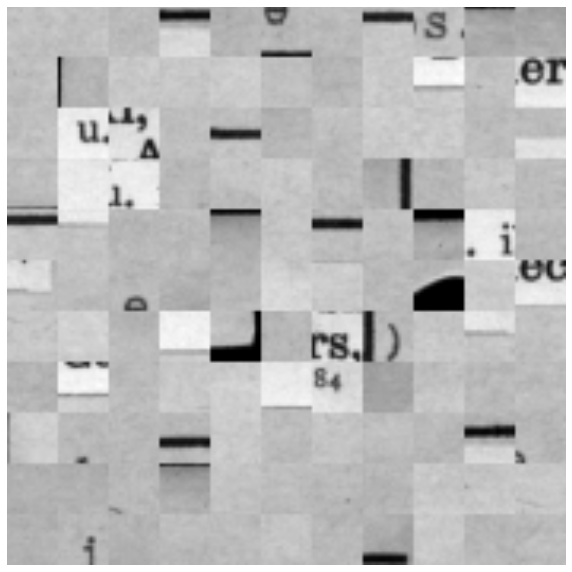

In [202]:
def img_grid(sample_selected, original_shape):
    n = int(math.floor(math.sqrt(len(sample_selected))))
    figure = np.zeros((original_shape[0] * n, original_shape[1] * n),np.float32)
    for i in range(0,n):
        for j in range(0,n):
            digit = sample_selected[j * n + i]
            figure[i * original_shape[0]: (i + 1) * original_shape[0],
                   j * original_shape[1]: (j + 1) * original_shape[1]] = digit
    return figure

fig = plt.figure(figsize=(10, 10))
ax = plt.imshow(img_grid(segments,  sample_shape),cmap='gray')
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
fig.savefig('../plots/random_tiles_bw.pdf')

In [35]:
pool = multiprocessing.Pool(processes=4)
images = np.concatenate(pool.map(random_img_tiles, sample_paths_from(catalog,k=1000)))
pool.close()
pool.join()
tiles_path = '/media/jakob/bigdata/train/tiles/S_Tiles_{}_{}_{}'.format(*images.shape)
np.save(tiles_path, images)
tiles_path

'/media/jakob/bigdata/train/tiles/S_Tiles_16000_16_16'

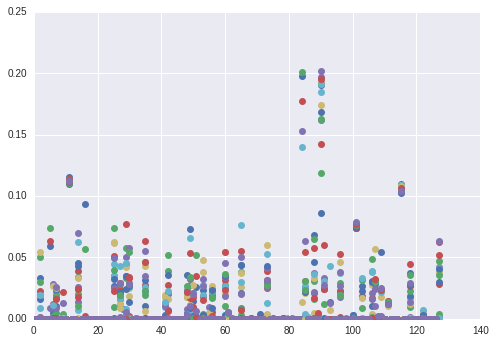

In [37]:
plt.plot(np.var(segments,1), 'o')
plt.show()

In [40]:
np.var(segments,1) > 0.025

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False,  True, ...,  True,  True,  True]], dtype=bool)

In [61]:
images = np.load('/media/jakob/bigdata/train/tiles/S_Tiles_16000_16_16.npy')
x_train = images[:int(len(images) * test_split)]
x_test  = images[int(len(images) * test_split):]
print(x_train.shape, x_train.dtype, 'Splitt: {}/{}'.format(len(x_train),len(x_test)))
images = 0

((11200, 16, 16), dtype('float32'), 'Splitt: 11200/4800')


In [161]:
def sampling(args):
    z_mean, z_log_std = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_std) * epsilon

def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x.flatten(), x_decoded_mean.flatten())
    kl_loss = - 0.5 * K.mean(1 + z_log_std - K.square(z_mean) - K.exp(z_log_std), axis=-1)
    return xent_loss + kl_loss

In [160]:
x.flatten()

Reshape{1}.0

In [204]:
batch_size       = 32
flat_dim         = TILE_SIZE * TILE_SIZE
latent_dim       = 2
intermediate_dim = 128
epsilon_std      = 0.01
nb_epoch         = 40

x         = Input(batch_shape=(batch_size, TILE_SIZE, TILE_SIZE))
flat      = Flatten()(x)
norm      = BatchNormalization()(flat)
h         = Dense(intermediate_dim, activation='relu')(norm)
z_mean    = Dense(latent_dim)(h)
z_log_std = Dense(latent_dim)(h)

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_std])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_std])

# we instantiate these layers separately so as to reuse them later
decoder_h      = Dense(intermediate_dim, activation='relu')
decoder_mean   = Dense(flat_dim,     activation='sigmoid')
h_decoded      = decoder_h(z)
x_decoded_mean = Reshape(x_train[0].shape)(decoder_mean(h_decoded))

# # build a digit generator that can sample from the learned distribution
# decoder_input   = Input(shape=(latent_dim,))
# _h_decoded      = decoder_h(decoder_input)
# _x_decoded_mean = Reshape(x_train[0].shape)(decoder_mean(_h_decoded))

# generator = Model(decoder_input, _x_decoded_mean)
vae       = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.n_epochs= 0 

In [205]:
print vae.output_shape
print generator.output_shape

((32, 2), 16, 16)
(None, 16, 16)


In [206]:
n_epochs = 40
history = vae.fit(x_train, x_train,
        verbose=0,
#         callbacks=[hera_model.callback],
        shuffle=False,
        nb_epoch=n_epochs,
        batch_size=batch_size,
#         validation_data=(x_test, x_test)
                 )
vae.n_epochs = vae.n_epochs + n_epochs
loss = np.concatenate([loss, history.history['loss']],0)

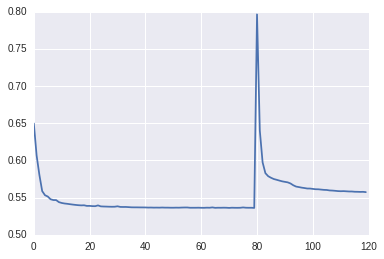

In [207]:
# loss = history.history['loss']
plt.plot(loss)

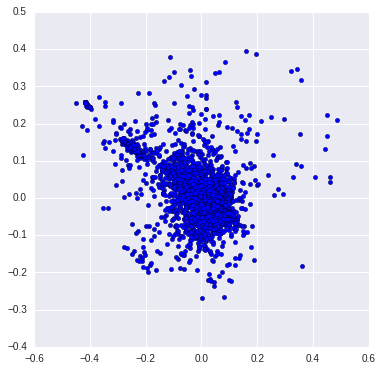

In [208]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
# plt.colorbar()
plt.show()

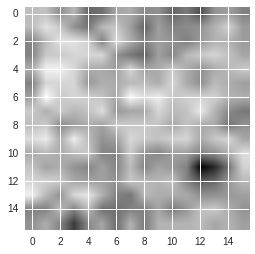

In [191]:
plt.imshow(x_test[2216],cmap='gray')

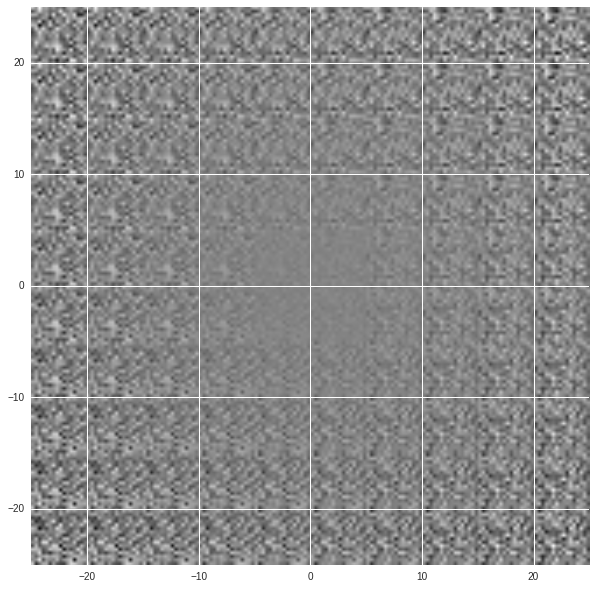

In [209]:
# display a 2D manifold of the digits
n = 10  # figure with 15x15 digits
figure = np.zeros((sample_shape[0] * n, sample_shape[1] * n))
# we will sample n points within [-15, 15] standard deviations
space = 25
grid_x = np.linspace(-space, space, n)
grid_y = np.linspace(-space, space, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0]
        figure[i * sample_shape[0]: (i + 1) * sample_shape[0],
               j * sample_shape[1]: (j + 1) * sample_shape[1]] = digit

        
fig = plt.figure(figsize=(10, 10))
plt.imshow(figure,extent=[-space,space,-space, space],cmap='gray')
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

fig.savefig('../plots/vae_{}_bw.pdf'.format(vae.n_epochs))